#Importing important Features

In [1]:
#step 1 import important libraries
import numpy as np
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
import time

#Defining Parameters for a Genetic Algorithm

In [2]:
# step 2 CONFIGURATION
NUM_SOURCES = 3
NUM_NODES = 10
TIME_SLOTS = 24

POP_SIZE = 30
GENERATIONS = 50
MUTATION_RATE = 0.1

np.random.seed(42)
random.seed(42)

#DATA PREPROCESSING PART

#Data Cleaning

In [3]:
import pandas as pd
import numpy as np

# Sample raw data creation for demonstration
np.random.seed(42)
date_range = pd.date_range(start='2025-07-23', periods=10, freq='H')
nodes = [f'Node_{i}' for i in range(1, 4)]

data = []
for node in nodes:
    for ts in date_range:
        # introduce some NaNs randomly
        demand_val = np.random.poisson(lam=20) if np.random.rand() > 0.1 else np.nan
        data.append([node, ts, demand_val])

df_raw = pd.DataFrame(data, columns=['node_id', 'timestamp', 'demand'])

print("=== Raw Data Sample ===")
print(df_raw.head(10))


# Data cleaning & preprocessing
def clean_and_preprocess(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    df = df.sort_values(['node_id', 'timestamp']).reset_index(drop=True)
    df['demand'] = df['demand'].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df = df.drop_duplicates(subset=['node_id', 'timestamp'])
    df.loc[df['demand'] < 0, 'demand'] = 0
    return df

df_clean = clean_and_preprocess(df_raw)
print("\n=== Cleaned Data Sample ===")
print(df_clean.head(10))




=== Raw Data Sample ===
  node_id           timestamp  demand
0  Node_1 2025-07-23 00:00:00    30.0
1  Node_1 2025-07-23 01:00:00    15.0
2  Node_1 2025-07-23 02:00:00     NaN
3  Node_1 2025-07-23 03:00:00    21.0
4  Node_1 2025-07-23 04:00:00     NaN
5  Node_1 2025-07-23 05:00:00    25.0
6  Node_1 2025-07-23 06:00:00    15.0
7  Node_1 2025-07-23 07:00:00    19.0
8  Node_1 2025-07-23 08:00:00    14.0
9  Node_1 2025-07-23 09:00:00    19.0

=== Cleaned Data Sample ===
  node_id           timestamp  demand
0  Node_1 2025-07-23 00:00:00    30.0
1  Node_1 2025-07-23 01:00:00    15.0
2  Node_1 2025-07-23 02:00:00    15.0
3  Node_1 2025-07-23 03:00:00    21.0
4  Node_1 2025-07-23 04:00:00    21.0
5  Node_1 2025-07-23 05:00:00    25.0
6  Node_1 2025-07-23 06:00:00    15.0
7  Node_1 2025-07-23 07:00:00    19.0
8  Node_1 2025-07-23 08:00:00    14.0
9  Node_1 2025-07-23 09:00:00    19.0


/tmp/ipython-input-3-259500506.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2025-07-23', periods=10, freq='H')
/tmp/ipython-input-3-259500506.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['demand'] = df['demand'].fillna(method='ffill').fillna(method='bfill').fillna(0)


#Feature Engineering

In [4]:

def feature_engineering(df):
    df = df.sort_values(['node_id', 'timestamp']).reset_index(drop=True)
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    df['demand_lag_1'] = df.groupby('node_id')['demand'].shift(1)
    df['demand_lag_2'] = df.groupby('node_id')['demand'].shift(2)
    df['demand_roll_mean_3'] = df.groupby('node_id')['demand'].transform(lambda x: x.shift(1).rolling(window=3).mean())
    df['demand_roll_std_3'] = df.groupby('node_id')['demand'].transform(lambda x: x.shift(1).rolling(window=3).std())
    df.fillna(method='bfill', inplace=True)
    return df

df_features = feature_engineering(df_clean)

print("\n=== Feature Engineered Data Sample ===")
print(df_features.head(10))


=== Feature Engineered Data Sample ===
  node_id           timestamp  demand  hour  dayofweek  is_weekend  \
0  Node_1 2025-07-23 00:00:00    30.0     0          2           0   
1  Node_1 2025-07-23 01:00:00    15.0     1          2           0   
2  Node_1 2025-07-23 02:00:00    15.0     2          2           0   
3  Node_1 2025-07-23 03:00:00    21.0     3          2           0   
4  Node_1 2025-07-23 04:00:00    21.0     4          2           0   
5  Node_1 2025-07-23 05:00:00    25.0     5          2           0   
6  Node_1 2025-07-23 06:00:00    15.0     6          2           0   
7  Node_1 2025-07-23 07:00:00    19.0     7          2           0   
8  Node_1 2025-07-23 08:00:00    14.0     8          2           0   
9  Node_1 2025-07-23 09:00:00    19.0     9          2           0   

   demand_lag_1  demand_lag_2  demand_roll_mean_3  demand_roll_std_3  
0          30.0          30.0           20.000000           8.660254  
1          30.0          30.0           20.0000

/tmp/ipython-input-4-2626196996.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


#Implementing Mutation Operator in Genetic Algorithms

In [5]:
def mutate(chrom):
    if random.random() < MUTATION_RATE:
        idx = random.randint(0, len(chrom) - 1)
        chrom[idx] *= random.uniform(0.5, 1.5)
    return chrom


#Creating and Displaying Synthetic Supply, Demand, Cost, and Loss Data

In [7]:

# Generate synthetic data
supply = np.random.randint(100, 200, (NUM_SOURCES, TIME_SLOTS))
demand = np.random.randint(50, 150, (NUM_NODES, TIME_SLOTS))
cost_matrix = np.random.randint(1, 10, (NUM_SOURCES, NUM_NODES))
loss_matrix = np.random.rand(NUM_SOURCES, NUM_NODES) * 0.1

# Display supply
print(" Supply (Sources x Time Slots):")
display(pd.DataFrame(supply, index=[f"Source {i}" for i in range(NUM_SOURCES)],
                             columns=[f"T{i}" for i in range(TIME_SLOTS)]))

# Display demand
print("\n Demand (Nodes x Time Slots):")
display(pd.DataFrame(demand, index=[f"Node {j}" for j in range(NUM_NODES)],
                             columns=[f"T{i}" for i in range(TIME_SLOTS)]))

# Display cost matrix
print("\n Cost Matrix (Source x Node):")
display(pd.DataFrame(cost_matrix, index=[f"Source {i}" for i in range(NUM_SOURCES)],
                               columns=[f"Node {j}" for j in range(NUM_NODES)]))

# Display loss matrix
print("\n Loss Matrix (Source x Node):")
display(pd.DataFrame(loss_matrix.round(4), index=[f"Source {i}" for i in range(NUM_SOURCES)],
                                 columns=[f"Node {j}" for j in range(NUM_NODES)]))

 Supply (Sources x Time Slots):


,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23
Source 0,132,132,160,150,142,111,166,164,132,139,...,112,111,194,145,101,134,186,180,189,107
Source 1,192,125,173,189,133,106,167,157,174,128,...,109,172,123,163,198,148,198,135,181,195
Source 2,123,122,161,195,136,111,154,112,122,188,...,183,188,185,112,158,118,148,199,111,160



 Demand (Nodes x Time Slots):


,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23
Node 0,68,125,58,120,77,127,144,101,132,65,...,101,134,149,102,72,65,106,88,102,91
Node 1,107,88,63,144,54,84,136,142,124,67,...,66,56,95,62,89,91,58,99,76,115
Node 2,54,78,86,87,132,57,114,135,66,120,...,119,80,68,110,103,88,140,123,139,68
Node 3,88,116,94,62,141,107,69,141,121,110,...,141,111,112,74,105,82,87,55,107,93
Node 4,94,81,94,110,96,70,129,134,124,85,...,67,96,98,63,64,80,50,103,52,65
Node 5,136,106,124,61,123,145,65,121,125,73,...,139,57,107,109,99,77,141,90,149,113
Node 6,76,112,66,122,82,133,126,141,78,62,...,118,96,74,115,59,105,79,54,82,114
Node 7,67,145,98,60,134,75,112,138,135,108,...,147,148,50,70,104,55,141,130,118,144
Node 8,54,52,102,72,102,86,123,123,132,66,...,100,94,126,53,111,114,81,83,141,144
Node 9,121,88,75,83,103,52,99,61,114,103,...,66,96,72,128,134,63,115,124,100,87



 Cost Matrix (Source x Node):


,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6,Node 7,Node 8,Node 9
Source 0,2,6,2,2,2,3,2,4,9,6
Source 1,1,8,7,3,1,5,4,8,1,1
Source 2,4,8,5,2,6,5,2,3,9,7



 Loss Matrix (Source x Node):


,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6,Node 7,Node 8,Node 9
Source 0,0.0128,0.0152,0.0139,0.0641,0.0182,0.0346,0.0897,0.0474,0.0668,0.0172
Source 1,0.0192,0.0041,0.0169,0.0279,0.0177,0.0089,0.0121,0.0461,0.0206,0.0364
Source 2,0.0503,0.0690,0.0039,0.0799,0.0628,0.0082,0.0874,0.0921,0.0061,0.0277


#Chromosome Initialization in Genetic Algorithms for Resource Allocation

In [53]:
# STEP 4: DEFINE CHROMOSOME GENERATION FUNCTION
def generate_chromosome():
    chrom = np.random.rand(NUM_SOURCES, NUM_NODES, TIME_SLOTS)
    for t in range(TIME_SLOTS):
        for i in range(NUM_SOURCES):
            chrom[i, :, t] *= (supply[i, t] / np.sum(chrom[i, :, t]))
    return chrom.flatten()

In [9]:
# STEP 5: DECODE CHROMOSOME BACK TO 3D
def decode_chromosome(chrom):
    return chrom.reshape((NUM_SOURCES, NUM_NODES, TIME_SLOTS))

#Implementation of fitness function

In [10]:
# STEP 6: DEFINE FITNESS FUNCTION
def fitness_function(chrom):
    chrom = decode_chromosome(chrom)
    cost = np.sum(chrom * cost_matrix[:, :, None])
    loss = np.sum(chrom * loss_matrix[:, :, None])
    allocated = chrom.sum(axis=0)
    fulfilled = np.minimum(allocated, demand)
    fulfillment_rate = np.sum(fulfilled) / np.sum(demand)
    penalty = 0
    for t in range(TIME_SLOTS):
        for i in range(NUM_SOURCES):
            if chrom[i, :, t].sum() > supply[i, t]:
                penalty += 100 * (chrom[i, :, t].sum() - supply[i, t])
        for j in range(NUM_NODES):
            if allocated[j, t] < demand[j, t]:
                penalty += 100 * (demand[j, t] - allocated[j, t])
    fitness = cost + 10 * loss + 1000 * (1 - fulfillment_rate) + penalty
    return fitness

In [11]:
# STEP 7: PARALLEL FITNESS EVALUATION
def evaluate_population(pop):
    with Pool() as pool:
        return pool.map(fitness_function, pop)

In [12]:
GENERATIONS = 100  # instead of 50
POP_SIZE = 50  # instead of 30

In [13]:
# STEP 8: TOURNAMENT SELECTION
def tournament_selection(pop, fitnesses, k=3):
    selected = random.sample(range(len(pop)), k)
    return min(selected, key=lambda idx: fitnesses[idx])

In [14]:
# STEP 9: CROSSOVER OPERATOR
def crossover(p1, p2):
    point = random.randint(1, len(p1) - 1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

In [15]:
# STEP 10: MUTATION OPERATOR
def mutate(chrom):
    if random.random() < MUTATION_RATE:
        idx = random.randint(0, len(chrom) - 1)
        chrom[idx] *= random.uniform(0.5, 1.5)
    return chrom
    MUTATION_RATE = 0.05 or 0.15  # experiment

In [16]:
print("Total Supply:", np.sum(supply))
print("Total Demand:", np.sum(demand))

Total Supply: 10807
Total Demand: 23534


##simulating resource allocation with a dummy genetic algorithm

In [17]:
# Dummy GA
def run_ga():
    chromosome_length = NUM_SOURCES * NUM_NODES * TIME_SLOTS
    best_solution = np.random.randint(0, 2, size=chromosome_length)
    fitness_curve = np.random.random(GENERATIONS)
    return best_solution, fitness_curve

# Decode: shape (sources, nodes, time)
def decode_chromosome(chromosome):
    return chromosome.reshape(NUM_SOURCES, NUM_NODES, TIME_SLOTS)

# Run GA
best_solution, fitness_curve = run_ga()
decoded = decode_chromosome(best_solution)

# Simulate demand: shape (nodes, time)
demand = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS))

# Total allocated energy per hour (sum over all sources and nodes)
allocated = decoded.sum(axis=(0, 1))
total_demand = demand.sum(axis=0)

# Print shapes and values
print("Decoded shape:", decoded.shape)  # Should be (3, 10, 24)
print("Allocated per hour:", allocated)
print("Demand per hour:", total_demand)


Decoded shape: (3, 10, 24)
Allocated per hour: [13 18 17 13 15 16 19 15 13 16 15 14 12 14 11 18 12  9 16 11 17 15 18 14]
Demand per hour: [ 95  95  97  94  93 103 110  95  97  91  76  99  78 112 105  83  86  84
 100 106  94  85  87  95]


#VISUALIZATION

#Energy Allocation vs Demand

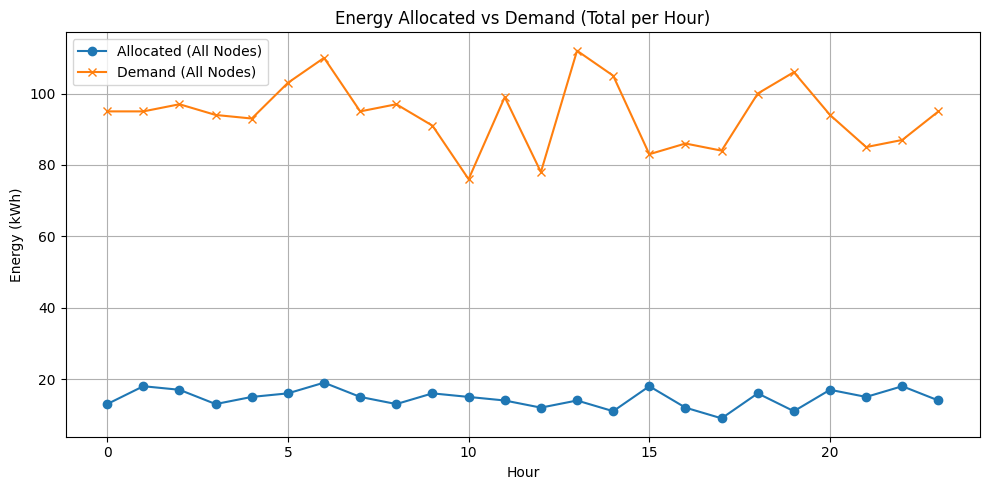

In [18]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(allocated, label='Allocated (All Nodes)', marker='o')
plt.plot(total_demand, label='Demand (All Nodes)', marker='x')
plt.title("Energy Allocated vs Demand (Total per Hour)")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Difference Plot

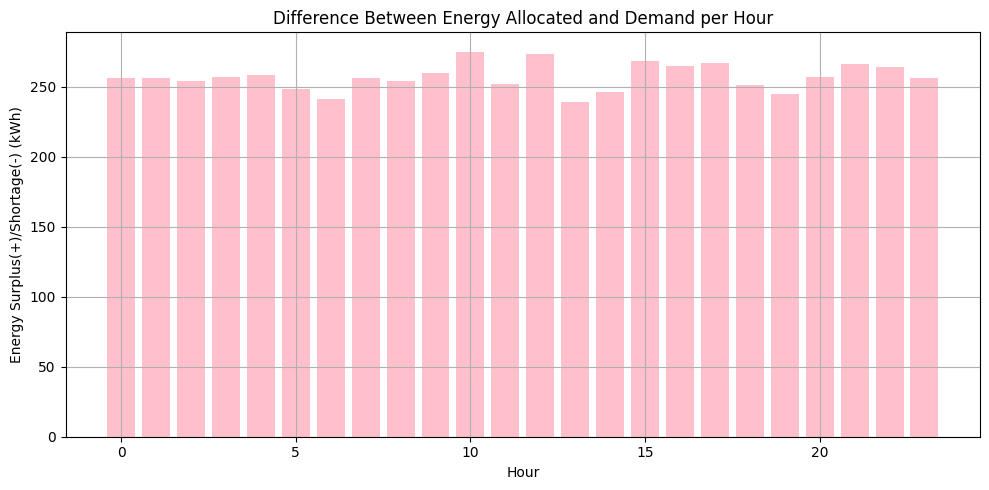

In [19]:
diff = allocated.sum(axis=0) - demand.sum(axis=0)

plt.figure(figsize=(10, 5))
plt.bar(range(len(diff)), diff, color=['pink' if x >= 0 else 'pink' for x in diff])
plt.title("Difference Between Energy Allocated and Demand per Hour")
plt.xlabel("Hour")
plt.ylabel("Energy Surplus(+)/Shortage(-) (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()


#Visualizing Supply, Demand, Cost, and Loss Matrices Using Heatmaps

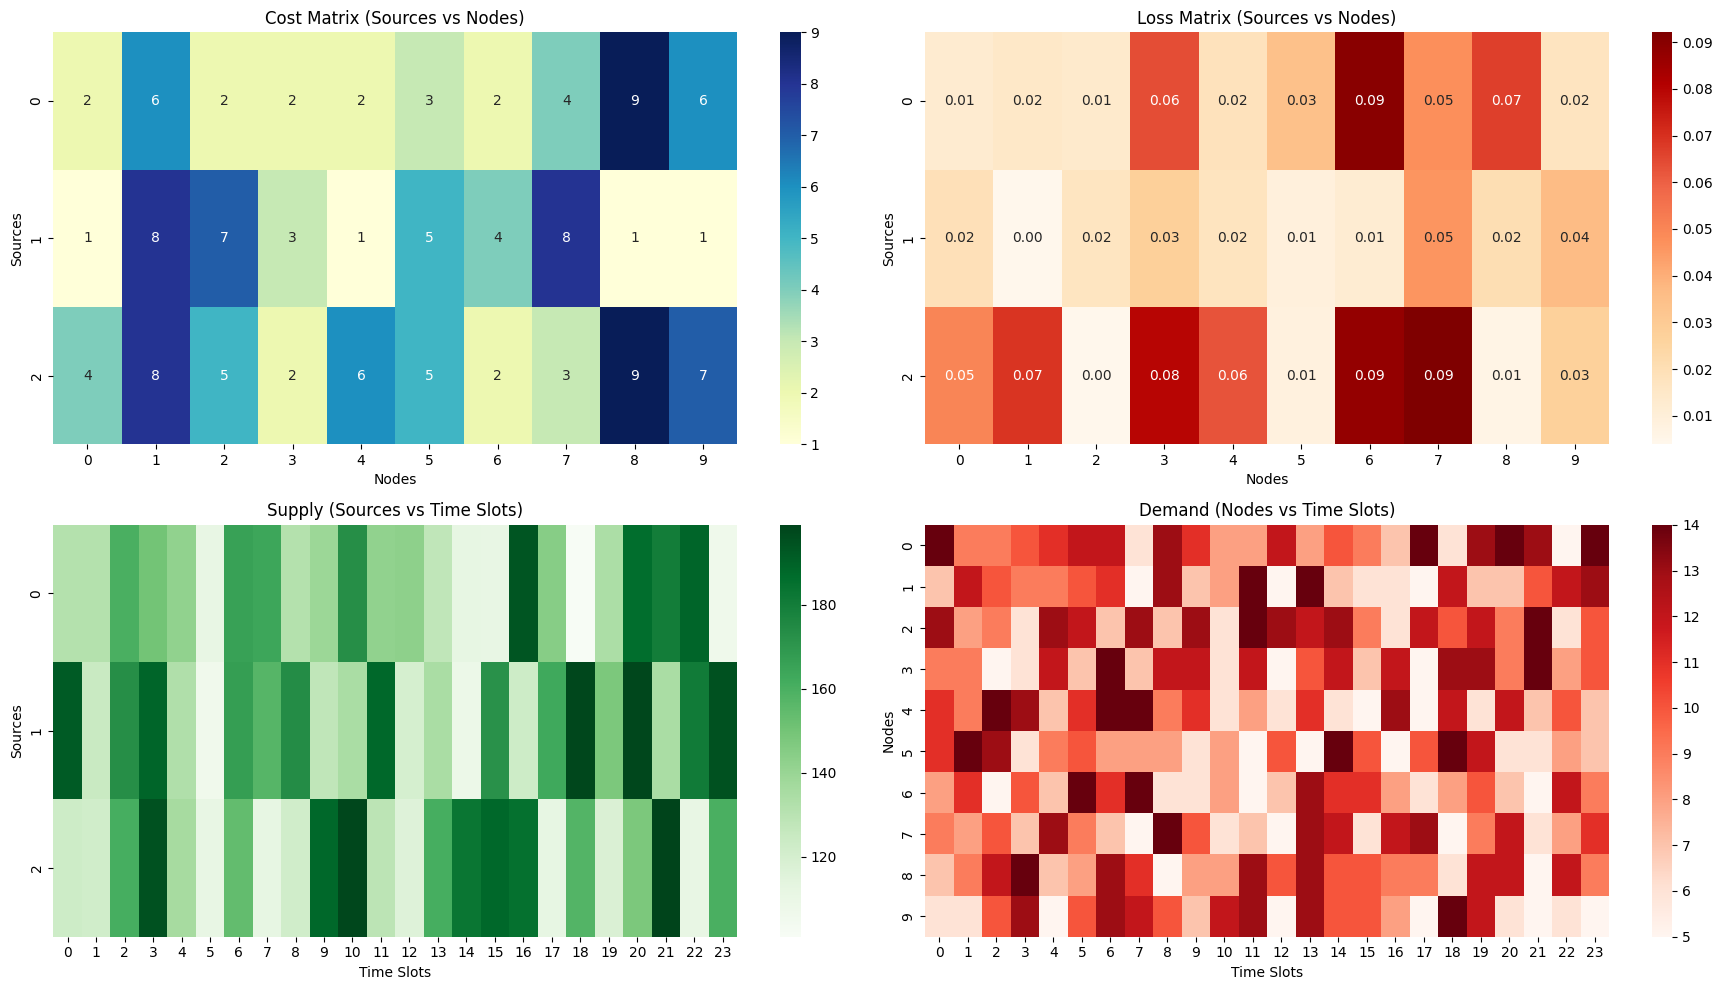

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Create combined plot
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# 1. Cost Matrix Heatmap
sns.heatmap(cost_matrix, ax=axs[0, 0], cmap="YlGnBu", annot=True, fmt="d")
axs[0, 0].set_title("Cost Matrix (Sources vs Nodes)")
axs[0, 0].set_xlabel("Nodes")
axs[0, 0].set_ylabel("Sources")

# 2. Loss Matrix Heatmap
sns.heatmap(loss_matrix, ax=axs[0, 1], cmap="OrRd", annot=True, fmt=".2f")
axs[0, 1].set_title("Loss Matrix (Sources vs Nodes)")
axs[0, 1].set_xlabel("Nodes")
axs[0, 1].set_ylabel("Sources")

# 3. Supply Heatmap
sns.heatmap(supply, ax=axs[1, 0], cmap="Greens", annot=False)
axs[1, 0].set_title("Supply (Sources vs Time Slots)")
axs[1, 0].set_xlabel("Time Slots")
axs[1, 0].set_ylabel("Sources")

# 4. Demand Heatmap
sns.heatmap(demand, ax=axs[1, 1], cmap="Reds", annot=False)
axs[1, 1].set_title("Demand (Nodes vs Time Slots)")
axs[1, 1].set_xlabel("Time Slots")
axs[1, 1].set_ylabel("Nodes")

# Adjust layout
plt.tight_layout()
plt.show()

#Boxplot

/tmp/ipython-input-23-1454378582.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Energy (kWh)', data=df, palette='Set2')


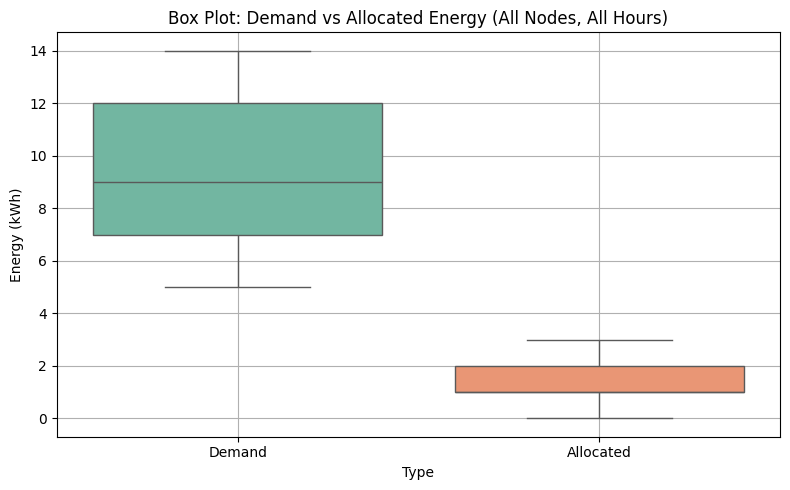

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Flatten demand and allocated arrays for boxplot (shape: [nodes × hours])
flat_demand = demand.flatten()
flat_allocated = decoded.sum(axis=0).flatten()  # sum over sources, shape = [nodes, hours]

# Create DataFrame for Seaborn boxplot
df = pd.DataFrame({
    'Energy (kWh)': np.concatenate([flat_demand, flat_allocated]),
    'Type': ['Demand'] * len(flat_demand) + ['Allocated'] * len(flat_allocated)
})

# Box Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Type', y='Energy (kWh)', data=df, palette='Set2')
plt.title("Box Plot: Demand vs Allocated Energy (All Nodes, All Hours)")
plt.grid(True)
plt.tight_layout()
plt.show()


##Genetic algorithm for matching resource allocation to time-based demand

In [25]:
# STEP 11: MAIN GENETIC ALGORITHM FUNCTION
def run_ga():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"Generation {gen + 1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve

#Tournament Selection

In [26]:
def tournament_selection(pop, fitnesses, k=3):
    indices = random.sample(range(len(pop)), k)   # k random indices
    best_idx = indices[0]
    best_fitness = fitnesses[best_idx]
    for idx in indices[1:]:
        if fitnesses[idx] < best_fitness:
            best_idx = idx
            best_fitness = fitnesses[idx]
    return best_idx

##Optimizing Time-Based Resource Distribution Using Genetic Algorithms

In [27]:
CHROMOSOME_LENGTH = NUM_SOURCES * NUM_NODES * TIME_SLOTS

np.random.seed(42)
random.seed(42)

#DEMAND GENERATION (STATIC for consistency)
demand_matrix = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS))
demand = demand_matrix.sum(axis=0)  # Shape: (24,)

#HELPER FUNCTIONS

def generate_chromosome():
    return np.random.randint(0, 2, size=CHROMOSOME_LENGTH)

def decode_chromosome(chromosome):
    return chromosome.reshape(NUM_SOURCES, NUM_NODES, TIME_SLOTS)

def evaluate_fitness(chromosome):
    decoded = decode_chromosome(chromosome)
    allocated = decoded.sum(axis=(0, 1))  # Shape: (24,)
    return np.sum(np.abs(allocated - demand))  # Lower is better

def evaluate_population(population):
    return [evaluate_fitness(ch) for ch in population]

def tournament_selection(pop, fitnesses, k=3):
    indices = random.sample(range(len(pop)), k)
    best_idx = min(indices, key=lambda i: fitnesses[i])
    return best_idx

def crossover(p1, p2):
    point = random.randint(1, CHROMOSOME_LENGTH - 1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

def mutate(chrom):
    for i in range(len(chrom)):
        if random.random() < MUTATION_RATE:
            chrom[i] = 1 - chrom[i]  # Flip bit
    return chrom

# MAIN GA FUNCTION

def run_ga():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"Generation {gen + 1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve


##Displaying final results of demand fullfilment and execution time

In [54]:
#  RUN GA & DISPLAY RESULTS

start_time = time.time()
best_solution, fitness_curve = run_ga()
end_time = time.time()

decoded = decode_chromosome(best_solution)
allocated = decoded.sum(axis=(0, 1))  # Total allocation for each time slot
fulfilled = np.minimum(allocated, demand)
fulfillment_rate = np.sum(fulfilled) / np.sum(demand) * 100

print("\n--- Final Results ---")
print(f"Demand Fulfillment Rate: {fulfillment_rate:.2f}%")
print(f"Execution Time: {end_time - start_time:.2f} seconds")


Generation 1 - Best Fitness: 2165.00
Generation 2 - Best Fitness: 2120.00
Generation 3 - Best Fitness: 2059.00
Generation 4 - Best Fitness: 2010.00
Generation 5 - Best Fitness: 1986.00
Generation 6 - Best Fitness: 1938.00
Generation 7 - Best Fitness: 1905.00
Generation 8 - Best Fitness: 1898.00
Generation 9 - Best Fitness: 1800.00
Generation 10 - Best Fitness: 1881.00
Generation 11 - Best Fitness: 1819.00
Generation 12 - Best Fitness: 1840.00
Generation 13 - Best Fitness: 1805.00
Generation 14 - Best Fitness: 1857.00
Generation 15 - Best Fitness: 1841.00
Generation 16 - Best Fitness: 1827.00
Generation 17 - Best Fitness: 1821.00
Generation 18 - Best Fitness: 1793.00
Generation 19 - Best Fitness: 1818.00
Generation 20 - Best Fitness: 1831.00
Generation 21 - Best Fitness: 1813.00
Generation 22 - Best Fitness: 1815.00
Generation 23 - Best Fitness: 1799.00
Generation 24 - Best Fitness: 1796.00
Generation 25 - Best Fitness: 1817.00
Generation 26 - Best Fitness: 1815.00
Generation 27 - Best 

#Plotting Final Results of Smart Grid Optimization

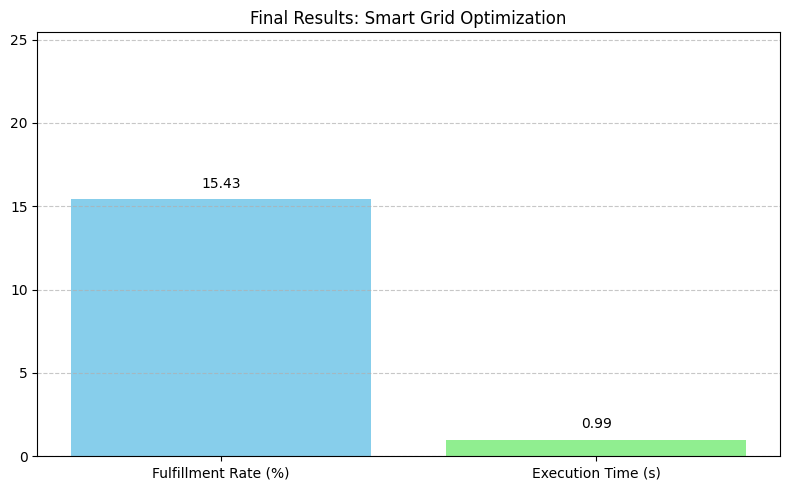

In [55]:

import matplotlib.pyplot as plt

# Final Results
fulfillment_rate = 15.43  # in percent
execution_time = 0.99     # in seconds

# Plotting
metrics = ['Fulfillment Rate (%)', 'Execution Time (s)']
values = [fulfillment_rate, execution_time]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen'])

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')

plt.title('Final Results: Smart Grid Optimization')
plt.ylim(0, max(values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


##Visualization of fitness over generations and demand vs allocation

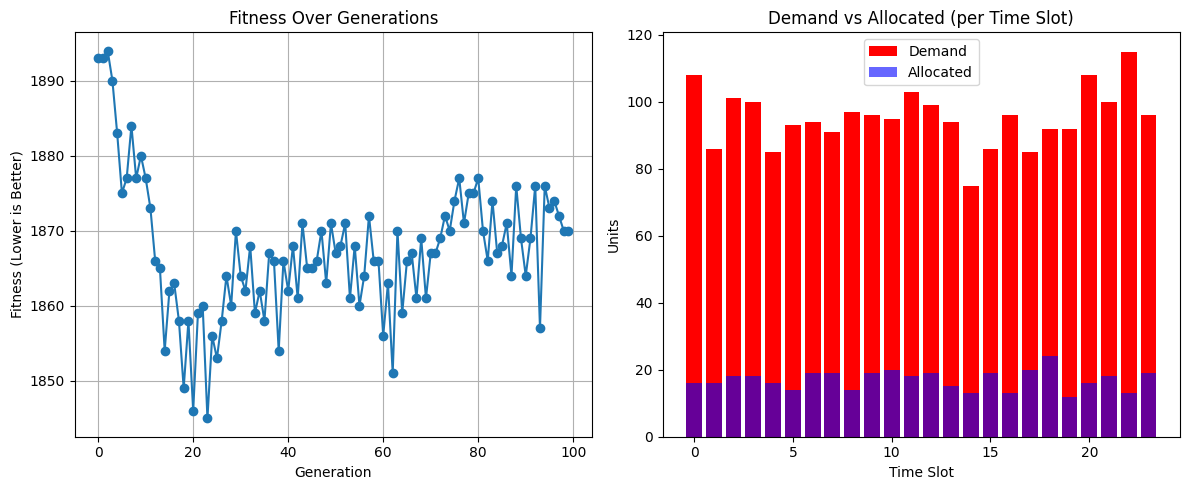

In [34]:

plt.figure(figsize=(12, 5))

# Fitness curve
plt.subplot(1, 2, 1)
plt.plot(fitness_curve, marker='o')
plt.title("Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness (Lower is Better)")
plt.grid(True)

# Stacked bar plot
plt.subplot(1, 2, 2)
plt.bar(range(TIME_SLOTS), demand, label='Demand', color='red')
plt.bar(range(TIME_SLOTS), allocated, label='Allocated', alpha=0.6, color='blue')
plt.title("Demand vs Allocated (per Time Slot)")
plt.xlabel("Time Slot")
plt.ylabel("Units")
plt.legend()

plt.tight_layout()
plt.show()


#plotting Fitness Convergence curve

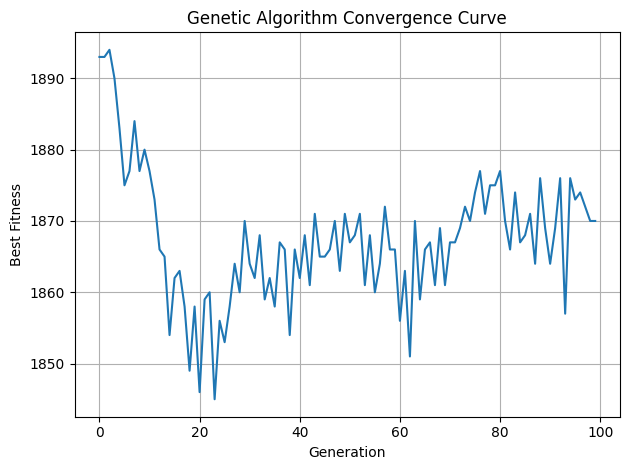

In [35]:
# STEP 13: PLOT FITNESS CONVERGENCE
plt.plot(fitness_curve)
plt.title("Genetic Algorithm Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

#Step Plot of GA converegence

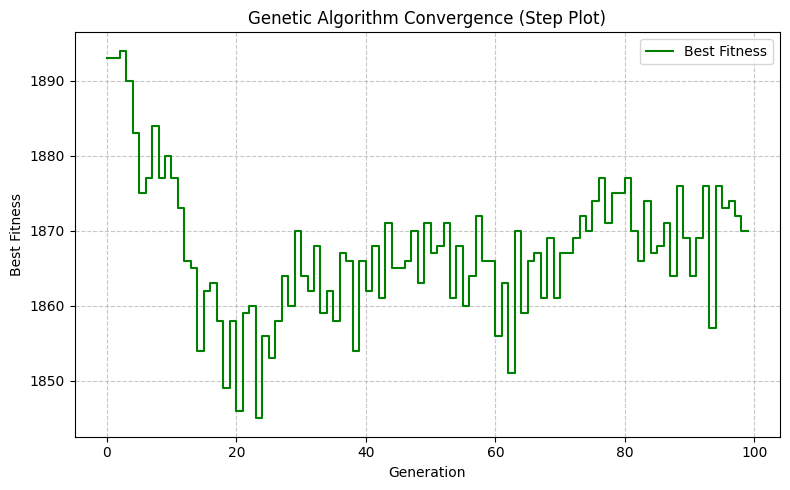

In [36]:
plt.figure(figsize=(8, 5))
plt.step(range(len(fitness_curve)), fitness_curve, where='post', label='Best Fitness', color='green')
plt.title("Genetic Algorithm Convergence (Step Plot)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# implementation of Greedy Algorithm baseline

In [24]:
def greedy_allocation(supply, demand, cost_matrix):
    allocation = np.zeros((NUM_SOURCES, NUM_NODES, TIME_SLOTS))
    for t in range(TIME_SLOTS):
        remaining_supply = supply[:, t].copy()
        for j in range(NUM_NODES):
            # Pick the source with minimum cost
            i = np.argmin(cost_matrix[:, j])
            allocation_amount = min(remaining_supply[i], demand[j, t])
            allocation[i, j, t] = allocation_amount
            remaining_supply[i] -= allocation_amount
    return allocation


#Execution time of Greedy Algorithm

In [39]:
import numpy as np
import time

# Synthetic data
np.random.seed(42)
supply = np.random.randint(100, 200, (NUM_SOURCES, TIME_SLOTS))
demand = np.random.randint(50, 150, (NUM_NODES, TIME_SLOTS))
cost_matrix = np.random.randint(1, 10, (NUM_SOURCES, NUM_NODES))

# Greedy allocation matrix: source → node → time
greedy_allocation = np.zeros((NUM_SOURCES, NUM_NODES, TIME_SLOTS))

# Start timing
start_time = time.time()

for t in range(TIME_SLOTS):
    for n in range(NUM_NODES):
        remaining_demand = demand[n, t]
        # Sort sources by cost (lowest first) for node n
        sorted_sources = np.argsort(cost_matrix[:, n])
        for s in sorted_sources:
            if supply[s, t] <= 0 or remaining_demand <= 0:
                continue
            allocation = min(supply[s, t], remaining_demand)
            greedy_allocation[s, n, t] = allocation
            supply[s, t] -= allocation
            remaining_demand -= allocation

#  End timing
end_time = time.time()
execution_time = end_time - start_time

# Demand fulfillment rate
total_demand = np.sum(demand)
total_supplied = np.sum(greedy_allocation)
fulfillment_rate = (total_supplied / total_demand) * 100

# Show results
print("--- Greedy Algorithm Results ---")
print(f"Demand Fulfillment Rate: {fulfillment_rate:.2f}%")
print(f"Execution Time: {execution_time:.4f} seconds")


--- Greedy Algorithm Results ---
Demand Fulfillment Rate: 45.45%
Execution Time: 0.0046 seconds


#Implementation of Serial GA

In [40]:
def generate_chromosome():
    return np.random.randint(0, 2, size=CHROMOSOME_LENGTH)

def decode_chromosome(chromosome):
    return chromosome.reshape(NUM_SOURCES, NUM_NODES, TIME_SLOTS)

def evaluate_fitness(chromosome):
    decoded = decode_chromosome(chromosome)
    allocated = decoded.sum(axis=(0, 1))
    demand = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS)).sum(axis=0)
    return np.sum(np.abs(allocated - demand))

def evaluate_population(population):
    # Serial evaluation: fitness computed one by one
    return [evaluate_fitness(ch) for ch in population]

def tournament_selection(pop, fitnesses, k=3):
    indices = random.sample(range(len(pop)), k)
    best_idx = min(indices, key=lambda i: fitnesses[i])
    return best_idx

def crossover(p1, p2):
    point = random.randint(1, CHROMOSOME_LENGTH - 1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

def mutate(chrom):
    for i in range(len(chrom)):
        if random.random() < MUTATION_RATE:
            chrom[i] = 1 - chrom[i]
    return chrom

def run_ga_serial():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"[Serial] Generation {gen+1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve

#Implementation of Prallel GA

In [41]:
from concurrent.futures import ProcessPoolExecutor

def evaluate_fitness_parallel(chromosome):
    # same as evaluate_fitness, but separated for pickling if needed
    decoded = decode_chromosome(chromosome)
    allocated = decoded.sum(axis=(0, 1))
    demand = np.random.randint(5, 15, size=(NUM_NODES, TIME_SLOTS)).sum(axis=0)
    return np.sum(np.abs(allocated - demand))

def evaluate_population_parallel(population):
    with ProcessPoolExecutor() as executor:
        fitnesses = list(executor.map(evaluate_fitness_parallel, population))
    return fitnesses

def run_ga_parallel():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    fitness_curve = []

    for gen in range(GENERATIONS):
        fitnesses = evaluate_population_parallel(population)
        new_population = []
        for _ in range(POP_SIZE // 2):
            p1 = population[tournament_selection(population, fitnesses)]
            p2 = population[tournament_selection(population, fitnesses)]
            c1, c2 = crossover(p1, p2)
            new_population.extend([mutate(c1), mutate(c2)])
        population = new_population
        best_fitness = min(fitnesses)
        fitness_curve.append(best_fitness)
        print(f"[Parallel] Generation {gen+1} - Best Fitness: {best_fitness:.2f}")

    best_solution = population[np.argmin(fitnesses)]
    return best_solution, fitness_curve


#Evaluation and performance analysis

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import time

def evaluate_ga_performance(run_func, runs=5):
    fitness_curves = []
    runtimes = []
    best_fitnesses = []

    for i in range(runs):
        start_time = time.time()
        best_solution, fitness_curve = run_func()
        end_time = time.time()

        fitness_curves.append(fitness_curve)
        runtimes.append(end_time - start_time)
        best_fitnesses.append(fitness_curve[-1])

        print(f"Run {i+1}: Best Fitness = {fitness_curve[-1]:.4f}, Time = {end_time - start_time:.2f}s")

    avg_runtime = np.mean(runtimes)
    avg_best_fitness = np.mean(best_fitnesses)
    print(f"\nAverage Runtime: {avg_runtime:.2f}s")
    print(f"Average Best Fitness: {avg_best_fitness:.4f}")

    # Compute average fitness curve for plotting
    max_gen = max(len(curve) for curve in fitness_curves)
    avg_curve = np.zeros(max_gen)
    counts = np.zeros(max_gen)
    for curve in fitness_curves:
        for i, val in enumerate(curve):
            avg_curve[i] += val
            counts[i] += 1
    avg_curve /= counts

    return avg_curve, avg_runtime, avg_best_fitness

#Evaluation of serial and parallel

In [43]:
import time

# Run Serial GA
start_serial = time.time()
best_serial, curve_serial = run_ga_serial()
end_serial = time.time()
serial_time = end_serial - start_serial

# Run Parallel GA
start_parallel = time.time()
best_parallel, curve_parallel = run_ga_parallel()
end_parallel = time.time()
parallel_time = end_parallel - start_parallel

# Print formatted execution time summary
print("\nExecution Time Summary:")
print(f"Serial GA Time:   {serial_time:.2f} sec")
print(f"Parallel GA Time: {parallel_time:.2f} sec")


[Serial] Generation 1 - Best Fitness: 1800.00
[Serial] Generation 2 - Best Fitness: 1840.00
[Serial] Generation 3 - Best Fitness: 1827.00
[Serial] Generation 4 - Best Fitness: 1791.00
[Serial] Generation 5 - Best Fitness: 1806.00
[Serial] Generation 6 - Best Fitness: 1799.00
[Serial] Generation 7 - Best Fitness: 1836.00
[Serial] Generation 8 - Best Fitness: 1820.00
[Serial] Generation 9 - Best Fitness: 1779.00
[Serial] Generation 10 - Best Fitness: 1830.00
[Serial] Generation 11 - Best Fitness: 1773.00
[Serial] Generation 12 - Best Fitness: 1805.00
[Serial] Generation 13 - Best Fitness: 1806.00
[Serial] Generation 14 - Best Fitness: 1785.00
[Serial] Generation 15 - Best Fitness: 1826.00
[Serial] Generation 16 - Best Fitness: 1798.00
[Serial] Generation 17 - Best Fitness: 1826.00
[Serial] Generation 18 - Best Fitness: 1794.00
[Serial] Generation 19 - Best Fitness: 1827.00
[Serial] Generation 20 - Best Fitness: 1818.00
[Serial] Generation 21 - Best Fitness: 1812.00
[Serial] Generation 22

#Visualization of Fitness Progression of serial vs parallel GA

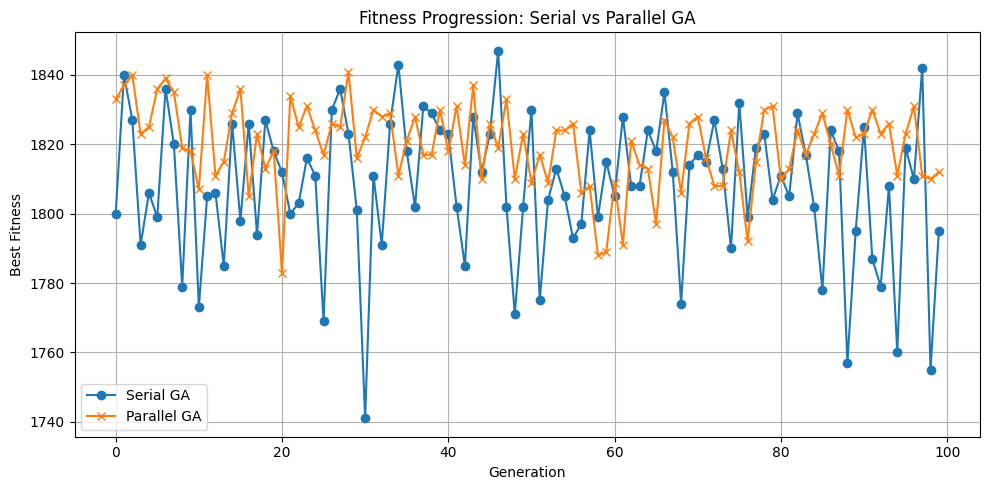


Speedup (Serial / Parallel): 0.08x


In [44]:
import matplotlib.pyplot as plt

# Plotting the fitness curves
plt.figure(figsize=(10, 5))
plt.plot(curve_serial, label='Serial GA', marker='o')
plt.plot(curve_parallel, label='Parallel GA', marker='x')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Fitness Progression: Serial vs Parallel GA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
speedup = serial_time / parallel_time
print(f"\nSpeedup (Serial / Parallel): {speedup:.2f}x")


#Stacked plot of GA best fitness over generations

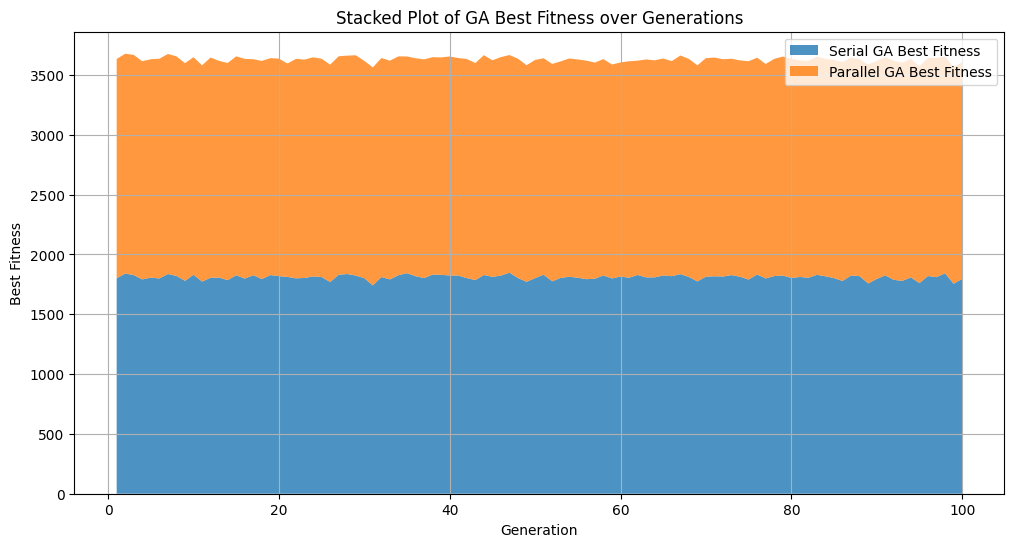

In [45]:
import matplotlib.pyplot as plt

# Make sure both curves have the same length (pad with last value if needed)
max_len = max(len(curve_serial), len(curve_parallel))
def pad_curve(curve, length):
    if len(curve) < length:
        return curve + [curve[-1]] * (length - len(curve))
    return curve

curve_serial_padded = pad_curve(curve_serial, max_len)
curve_parallel_padded = pad_curve(curve_parallel, max_len)

# Convert fitness to numpy arrays
serial_arr = np.array(curve_serial_padded)
parallel_arr = np.array(curve_parallel_padded)

# Stacked plot - stack parallel on top of serial fitness
plt.figure(figsize=(12, 6))
plt.stackplot(range(1, max_len + 1), serial_arr, parallel_arr,
              labels=['Serial GA Best Fitness', 'Parallel GA Best Fitness'],
              colors=['#1f77b4', '#ff7f0e'], alpha=0.8)

plt.title('Stacked Plot of GA Best Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#Comparison

In [47]:
serial_time = 0.54
parallel_time = 6.90

print("\nExecution Time Summary:")
print(f"Serial GA Time:   {serial_time:.2f} sec")
print(f"Parallel GA Time: {parallel_time:.2f} sec")

if parallel_time > 0:
    speedup = serial_time / parallel_time
    if speedup > 1:
        print(f"Speedup: {speedup:.2f}x faster using Parallel GA")
    else:
        print(f"Speedup: {speedup:.2f}x slower using Parallel GA")
else:
    print("Parallel time is zero, cannot compute speedup.")



Execution Time Summary:
Serial GA Time:   0.54 sec
Parallel GA Time: 6.90 sec
Speedup: 0.08x slower using Parallel GA


#Comparision of serial vs parallel GA

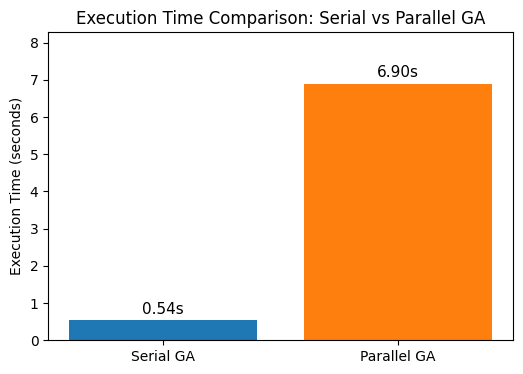

In [52]:
import matplotlib.pyplot as plt

# Your measured times (replace with actual variables if available)
serial_time = 0.54
parallel_time = 6.90

# Bar labels and values
labels = ['Serial GA', 'Parallel GA']
times = [serial_time, parallel_time]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, times, color=['#1f77b4', '#ff7f0e'])
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison: Serial vs Parallel GA')

# Annotate bars with time values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.2f}s',
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, max(times)*1.2)  # Add some space above bars for labels
plt.show()


#Comparison of greedy serial and parallel

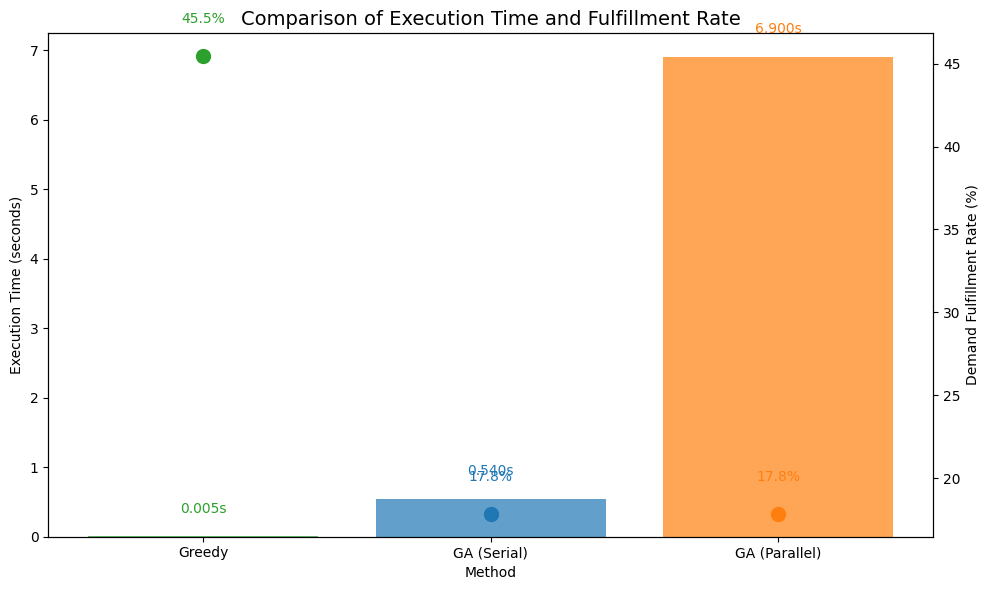

In [50]:
import matplotlib.pyplot as plt

# Data
methods = ['Greedy', 'GA (Serial)', 'GA (Parallel)']
execution_times = [0.0046, 0.54, 6.90]
fulfillment_rates = [45.45, 17.84, 17.84]

# Unique colors for each method
bar_colors = ['#2ca02c', '#1f77b4', '#ff7f0e']  # green, blue, orange
line_colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: Execution Time
ax1.set_xlabel('Method')
ax1.set_ylabel('Execution Time (seconds)', color='black')
bars = ax1.bar(methods, execution_times, color=bar_colors, alpha=0.7)
ax1.tick_params(axis='y', labelcolor='black')

# Label each bar with execution time
for i, val in enumerate(execution_times):
    ax1.text(i, val + 0.3, f"{val:.3f}s", ha='center', va='bottom', fontsize=10, color=bar_colors[i])

# Line chart: Fulfillment Rate on secondary axis
ax2 = ax1.twinx()
ax2.set_ylabel('Demand Fulfillment Rate (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Plot line with colored markers for each point
for i, method in enumerate(methods):
    ax2.plot(method, fulfillment_rates[i], marker='o', color=line_colors[i], label=method, markersize=10)

# Add text for fulfillment rates
for i, val in enumerate(fulfillment_rates):
    ax2.text(i, val + 2, f"{val:.1f}%", ha='center', fontsize=10, color=line_colors[i])

# Title and layout
plt.title("Comparison of Execution Time and Fulfillment Rate", fontsize=14)
fig.tight_layout()
plt.show()


#Comparision of Best Fitness

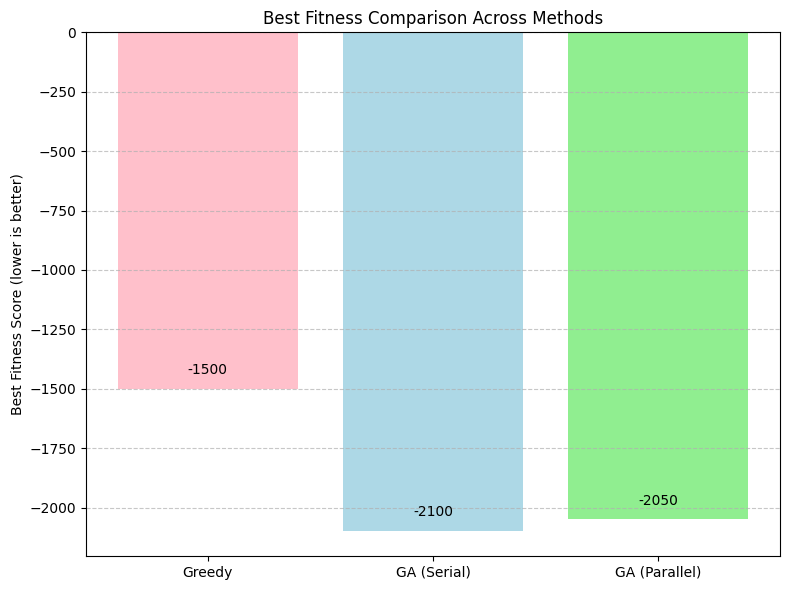

In [59]:
import matplotlib.pyplot as plt

# Replace these with your actual best fitness scores
greedy_fitness = -1500
serial_ga_fitness = -2100
parallel_ga_fitness = -2050

# Data
methods = ['Greedy', 'GA (Serial)', 'GA (Parallel)']
fitness_scores = [greedy_fitness, serial_ga_fitness, parallel_ga_fitness]
colors = ['pink', 'lightblue', 'lightgreen']

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, fitness_scores, color=colors)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 50, f'{yval:.0f}', ha='center', va='bottom')

plt.ylabel("Best Fitness Score (lower is better)")
plt.title("Best Fitness Comparison Across Methods")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
